In [1]:
import importlib.machinery
import importlib.util
loader = importlib.machinery.SourceFileLoader('baltic','/Users/evogytis/Documents/baltic/baltic.py')
spec = importlib.util.spec_from_loader(loader.name, loader)
bt = importlib.util.module_from_spec(spec)
loader.exec_module(bt)

import re,glob,os,json
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

typeface='Helvetica Neue'
# mpl.rcParams['font.weight']=300
# mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def dist2root(node):
    cur_node=node
    lvl=0
    while cur_node:
        cur_node=cur_node.parent
        lvl+=1
        
    return lvl

new_virus={}
pol2contigs={}
virus=json.load(open('/Users/evogytis/Documents/manuscripts/skeeters/data/darkmatter/virus.json','r'))
for pol in virus:
    pol2contigs[pol]=[]
    if 'provisional_name' in virus[pol]:
        new_virus[pol]=True
    else:
        new_virus[pol]=False
        
    for seg in virus[pol]['segments']:
        for contig in virus[pol]['segments'][seg]['contigs']:
            pol2contigs[pol].append(contig)

pol2colour={}
for line in open('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig3/virus_color_scheme.tsv','r'):
    l=line.strip('\n').split('\t')
    pol2colour[l[0]]=l[-1]
            
base_path='/Users/evogytis/Documents/manuscripts/skeeters/data/trees/fig7_branchLength/'

Xs={}
Ys={}
Cs={}


Tree height: 8.100000
Tree length: 48.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 23 (11 nodes and 12 leaves)

Rhabdo-like
[1.6669162000000002, 0.007158070000000016, 0.0] 1.6740742700000002
Xinmo
[0.000966, 0.0, 0.0014454299999999698, 0.5968219499999998, 0.019582820000000112, 0.0014659200000002315, 0.0010481399999999752, 0.000468, 0.0, 0.02090946000000038, 0.000929, 0.000464, 0.0, 0.0, 0.0013934899999998862, 0.000928, 0.0, 0.0] 0.6464222100000004
Dimarhabdo
[0.000479, 0.000956, 0.0, 0.000478, 0.000478, 0.0023971399999997978, 0.000479, 0.000477] 0.005744139999999799
Chu
[0.000586, 0.000612, 9.6e-05, 0.000741, 0.000874] 0.002909
CytoNucleorhabdo-like
[0.07225459999999995, 0.26738952000000005, 0.0025439099999999826, 0.0024482399999996574, 0.2803034499999999, 0.01706805999999972, 0.004309880000000099] 0.6463176599999993
Xinmo True
Rhabdo-like True
CytoNucleorhabdo-like True
Dimarhabdo True
Chu True


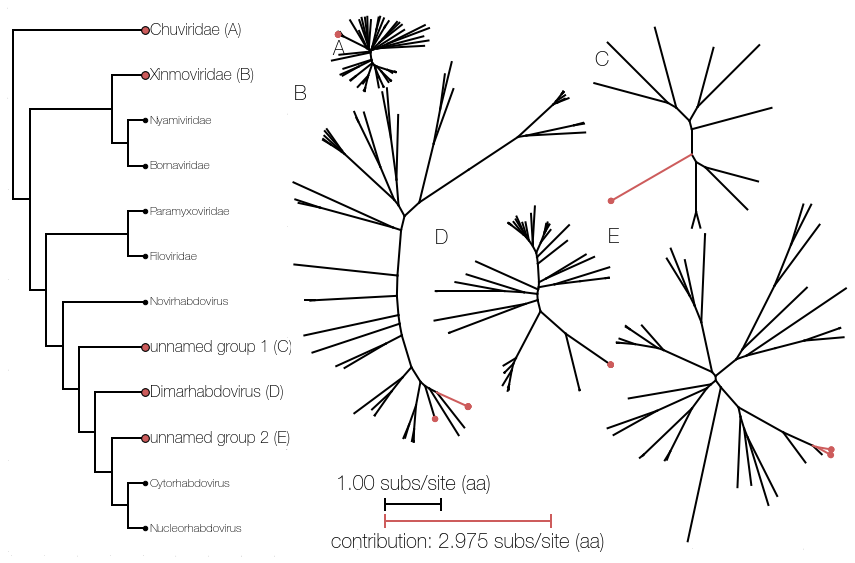

In [2]:
## Mononega-Chu

tree='((("Xinmoviridae"[&subtree="Xinmo"],("Nyamiviridae","Bornaviridae")),(("Paramyxoviridae","Filoviridae"),("Novirhabdovirus",("unnamed group 1"[&subtree="Rhabdo-like"],(("unnamed group 2"[&subtree="CytoNucleorhabdo-like"],("Cytorhabdovirus","Nucleorhabdovirus")),"Dimarhabdovirus"[&subtree="Dimarhabdo"]))))),"Chuviridae"[&subtree="Chu"]);'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)
    
for k in ll.Objects:
    k.length=k.height-k.parent.height
    
ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Chu': (-3.2,5.2,'A'), 'Xinmo': (-2,3,'B'), 'Rhabdo-like': (2,3.5,'C'), 'Dimarhabdo': (0,1,'D'), 'CytoNucleorhabdo-like': (3.5,-0.2,'E')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Mononega-Chu/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs)+0.0,max(ys)-0.4,label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-3.5
y=-3
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan+5)
ax.set_ylim(0,ll.ySpan)

pad=0.05
ax2.set_xlim(min(all_xs)-pad,max(all_xs)+pad)
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_mononega.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_mononega.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 5.100000
Tree length: 23.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 15 (7 nodes and 8 leaves)

Orthobunya
[0.7313928400000003] 0.7313928400000003
PhasmaFeraJon
[0.5009518000000002, 0.0, 0.000453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000453, 0.0, 0.000453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.51612204, 0.0014710899999998972, 0.0018378300000003733, 0.0014155999999996283, 0.0, 0.0, 0.000471, 0.0014171100000002212, 0.000472, 0.000469, 0.0014171999999996743, 0.0, 0.000939, 0.0, 0.000471, 0.000471, 0.000469, 0.000943, 0.0, 0.0014151099999999417, 0.0, 0.000471, 0.0, 0.0, 0.0, 0.0, 0.0] 1.0330357800000005
Phlebo-like
[0.43655187999999967, 0.000356, 0.0018592799999996856, 0.000882, 0.006223620000000096, 0.0035487500000002115, 0.0013271100000000757, 0.0017711800000004274, 0.000884, 0.000442, 0.000442, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000392, 0.0, 0.000786, 0.0, 0.000392, 0.0, 0.0, 0.0, 0.000392, 0.0, 0.000784, 0.0, 0.00

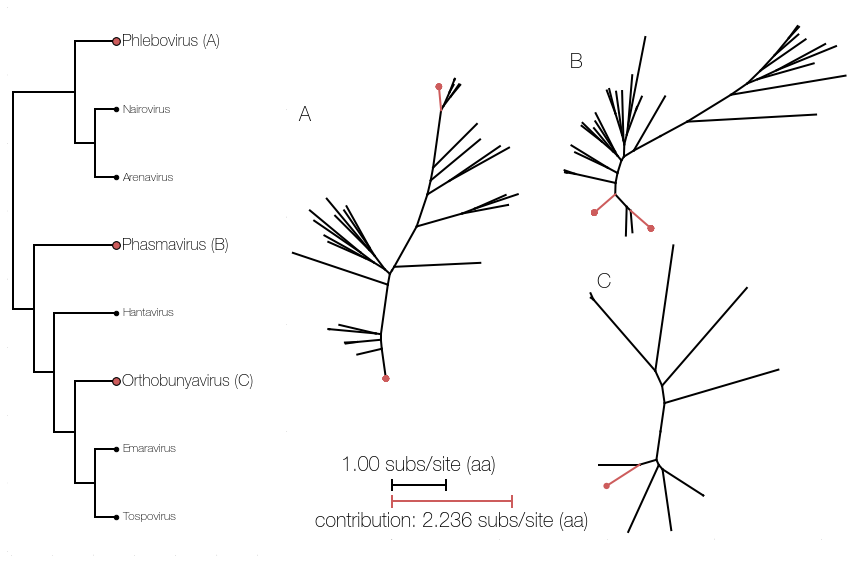

In [3]:
## Bunya

tree='(("Phasmavirus"[&subtree="PhasmaFeraJon"],("Hantavirus",("Orthobunyavirus"[&subtree="Orthobunya"],("Emaravirus","Tospovirus")))),("Phlebovirus"[&subtree="Phlebo-like"],("Nairovirus","Arenavirus")));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)
    
for k in ll.Objects:
    k.length=k.height-k.parent.height
    
ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Phlebo-like': (-2,3,'A'),'PhasmaFeraJon': (3,5.5,'B'), 'Orthobunya': (3,0,'C')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Bunya/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs)+0.1,max(ys)-0.5,label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-2
y=-1
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan*1.7)
ax.set_ylim(0,ll.ySpan)

pad=0.05
ax2.set_xlim(min(all_xs)-pad,max(all_xs)+pad)
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_bunya.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_bunya.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 3.100000
Tree length: 9.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 7 (3 nodes and 4 leaves)

Orthomyxo
[0.35466467999999995, 0.0, 0.0022845299999998403, 0.0019640199999999552, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36409356999999964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011521899999999974, 0.0, 0.0, 0.0022590100000003943, 0.0, 0.0011311999999996658, 0.0011274800000000695, 0.0, 0.0011270300000001399, 0.0, 0.0, 0.0, 0.0, 0.004513619999999996, 0.0, 0.0, 0.0011265900000001494, 0.0, 0.0, 0.0011249500000003465, 0.0, 0.0, 0.001128089999999915, 0.0, 0.002262499999999612, 0.0011265299999996259] 0.7410859899999993
Orthomyxo True


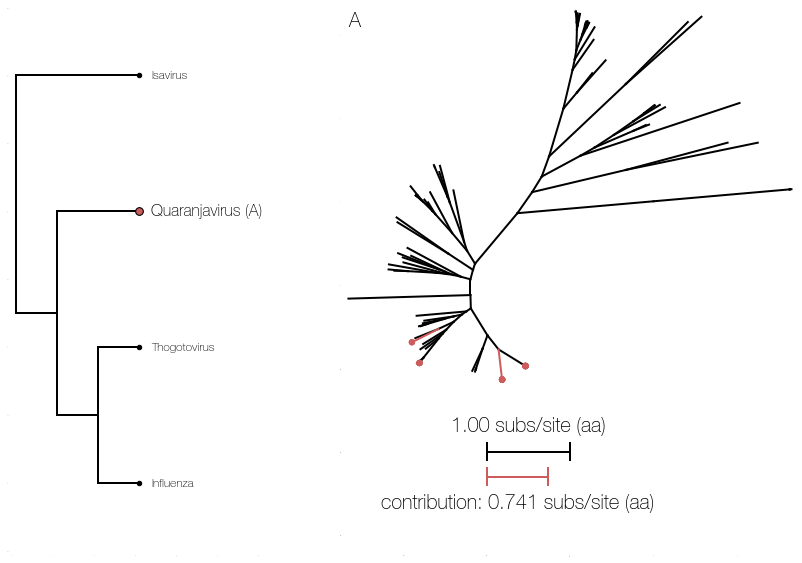

In [4]:
## Orthomyxo

tree='("Isavirus",(("Thogotovirus","Influenza"),"Quaranjavirus"[&subtree="Orthomyxo"]));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Orthomyxo': (0,1,'A')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Orthomyxo/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-2
y=-2
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan*1.7)
ax.set_ylim(0,ll.ySpan)

pad=0.05
ax2.set_xlim(min(all_xs)-pad,max([max(all_xs)+pad,contribution+pad]))
ax2.set_ylim(min(all_ys)-pad-2,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_orthomyxo.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_orthomyxo.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 4.100000
Tree length: 14.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 9 (4 nodes and 5 leaves)

Levi
[1.0365209700000002, 0.5156125999999999] 1.55213357
Narna
[0.30823197] 0.30823197
Narna-like
[0.03227042000000013, 0.06464670999999989, 0.06069195999999977, 0.009696589999999894, 0.005711429999999851, 0.00336886000000014, 0.004523229999999767, 0.0, 0.005723019999999579, 0.0, 0.004534070000000057, 0.0, 0.00899472999999995, 0.0015525699999998643, 0.0011409399999999792, 0.0012818000000001106, 0.0025764600000002247, 0.0, 0.0011352100000001641, 0.0, 0.0026073099999996963, 0.006792920000000535, 0.001978789999999897, 0.0013080700000003276, 0.003959990000000246, 0.0018703399999999704, 0.0033805899999999056, 0.007431610000000255, 0.0016005599999999731, 0.0022543999999999897, 0.0, 0.0, 0.000813, 0.004651270000000096, 2.3e-05, 0.0022889299999997448, 0.000304, 0.0035716500000004814, 0.012810660000000418, 0.001363589999999526, 0.014660219999999669, 

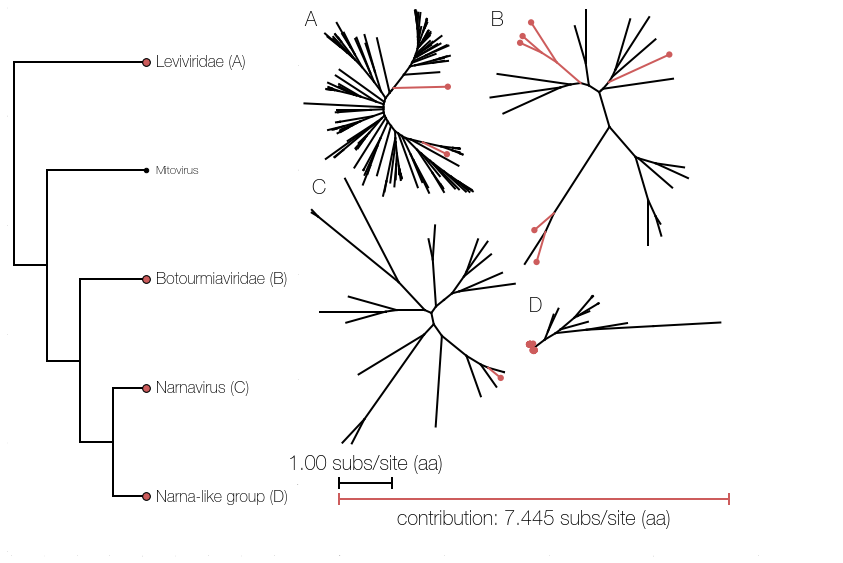

In [5]:
## Narna

tree='("Leviviridae"[&subtree="Levi"],("Mitovirus",("Botourmiaviridae"[&subtree="Botourmia"],("Narnavirus"[&subtree="Narna"],"Narna-like group"[&subtree="Narna-like"]))));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Levi': (-1,5.5,'A'), 'Botourmia': (3,5.5,'B'),'Narna': (0,1.5,'C'),'Narna-like': (4,1,'D')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'NarnaLevi/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-2
y=-2
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan*1.7)
ax.set_ylim(0,ll.ySpan)

pad=0.05
ax2.set_xlim(min(all_xs)-pad,max([max(all_xs)+pad,contribution+pad]))
ax2.set_ylim(min(all_ys)-pad-2,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_narna.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_narna.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 5.100000
Tree length: 22.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 15 (7 nodes and 8 leaves)

Partiti-like
[0.37018163999999976, 0.0, 0.0021418799999999294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019469600000001641, 0.0, 7.9e-05, 0.0, 0.0023029000000001076, 0.0, 0.0, 0.0, 0.002301779999999809, 0.0, 0.0, 0.004913870000000209, 0.002302119999999963, 0.6403690499999994, 0.0, 0.005473079999999797, 0.0, 0.003683880000000528, 0.011069979999999369, 0.0018355500000000191, 0.003641360000000482, 0.0055424899999998445, 0.0, 0.0018336400000000808, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 1.0596191799999994
Partiti-like True


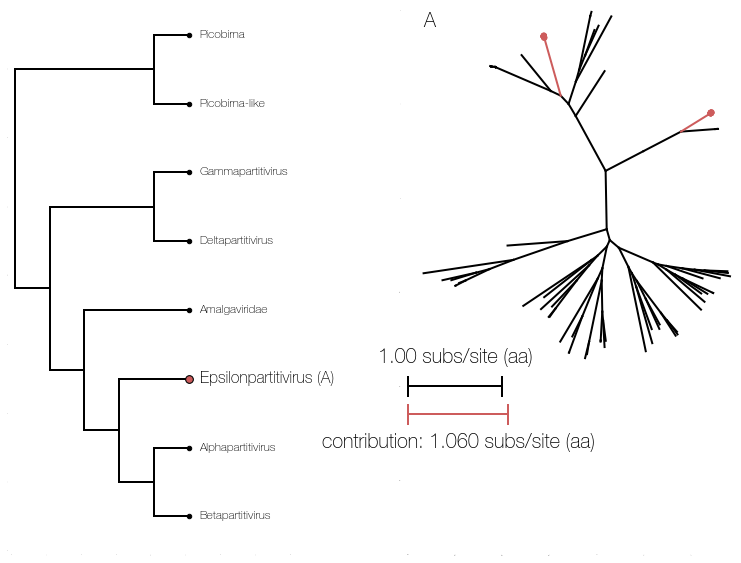

In [6]:
## Partiti

tree='(("Picobirna","Picobirna-like"),(("Gammapartitivirus","Deltapartitivirus"),("Amalgaviridae",(("Alphapartitivirus","Betapartitivirus"),"Epsilonpartitivirus"[&subtree="Partiti-like"]))));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Partiti-like': (0.5,0.5,'A')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Partiti/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-2
y=-2
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad-2,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_partiti.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_partiti.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 3.100000
Tree length: 10.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 9 (4 nodes and 5 leaves)

Pesti-like
[1.0904496, 0.0, 0.0031537199999998045, 0.0, 0.007903049999999912] 1.1015063699999996
Flavi-like
[0.0038824400000000425, 0.0012961199999999007, 0.0, 0.0, 0.002588599999999941] 0.007767159999999884
Pesti-like True
Flavi-like True


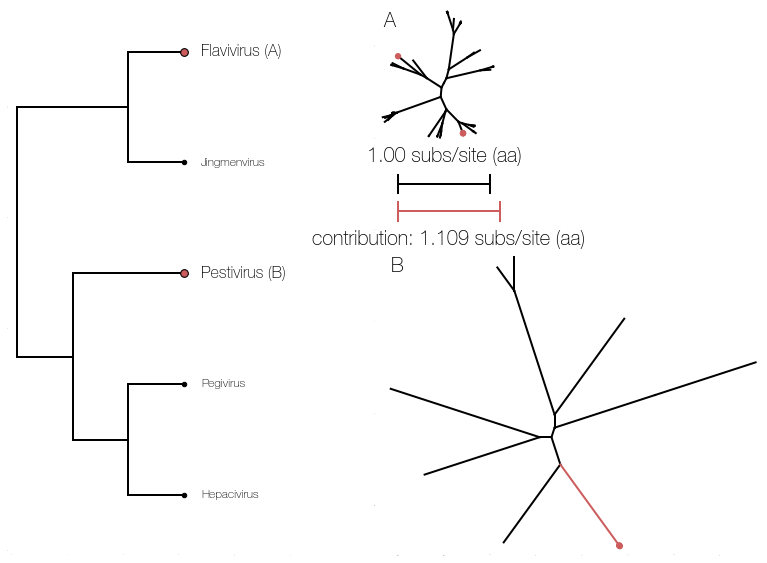

In [7]:
## Flavi

tree='(("Pestivirus"[&subtree="Pesti-like"],("Pegivirus","Hepacivirus")),("Flavivirus"[&subtree="Flavi-like"],"Jingmenvirus"));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Flavi-like': (-0.5,3.6,'A'),'Pesti-like': (1.8,0.2,'B')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Flavi/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=2.5
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_flavi.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_flavi.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 3.100000
Tree length: 10.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 9 (4 nodes and 5 leaves)

Polero-like
[0.6074811899999999] 0.6074811899999999
MottsMills-like
[0.0, 0.0, 0.0024734300000002207, 0.0024675699999998635, 0.007427439999999841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07748476999999987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002141910000000191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0028669799999998524, 0.0028671500000001515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010536309999999993, 0.0] 0.10826555999999998
LaTardoire-like
[0.0022642799999998964, 0.0, 0.0022696299999998004, 0.0020657200000000486,

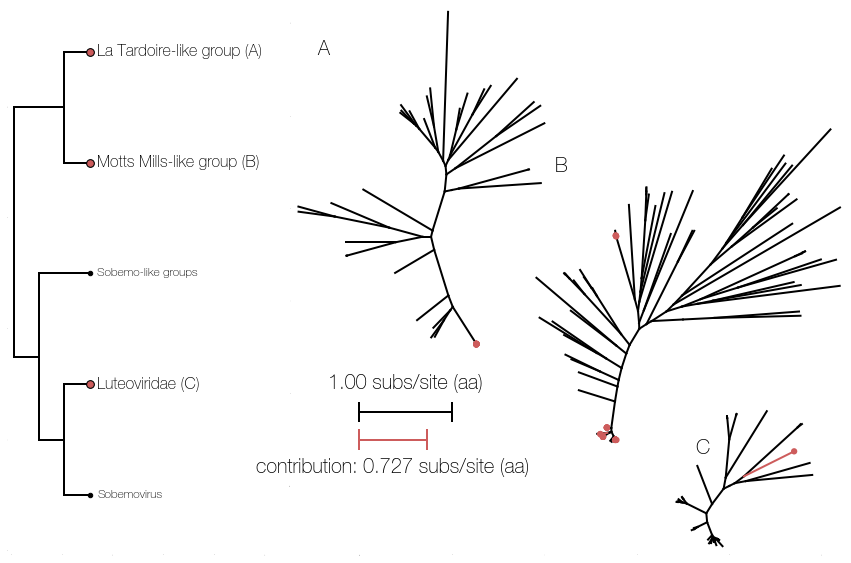

In [8]:
## Solemo

tree='(("La Tardoire-like group"[&subtree="LaTardoire-like"],"Motts Mills-like group"[&subtree="MottsMills-like"]),(("Luteoviridae"[&subtree="Polero-like"],"Sobemovirus"),"Sobemo-like groups"));'

ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'LaTardoire-like': (0,2.2,'A'), 'MottsMills-like': (2.5,0.8,'B'), 'Polero-like': (3,-1,'C')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Solemo/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs)+0.2,max(ys)-0.3,label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=-0.2
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left',clip_on=False)
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan+6)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_solemo.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_solemo.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 6.100000
Tree length: 36.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 23 (11 nodes and 12 leaves)

Orbi-like
[0.06997104999999948, 0.14567128000000018] 0.21564232999999966
Cypo
[0.2777506700000001, 0.0, 0.0, 0.0015928700000000795, 0.000796, 0.0, 0.003986450000000197] 0.2841259900000004
Orbi-like True
Cypo True


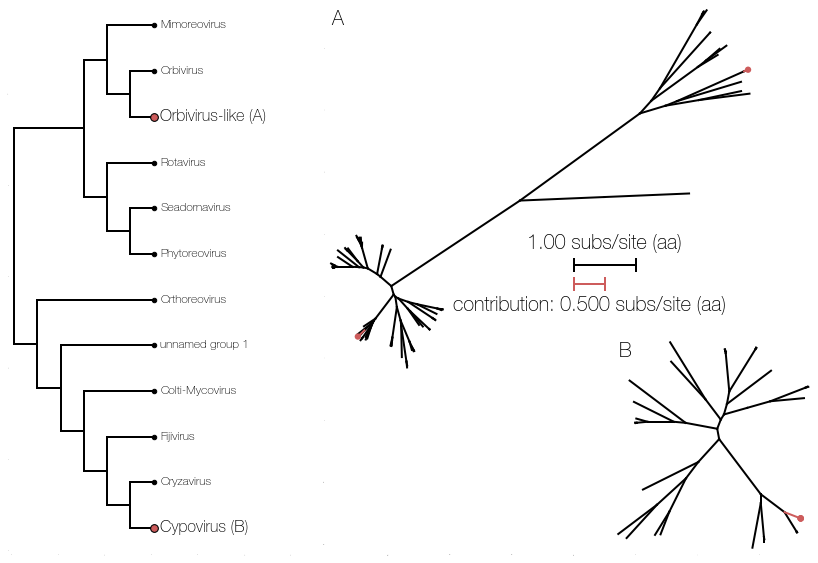

In [9]:
## Reo

tree='(((("Orbivirus","Orbivirus-like"[&subtree="Orbi-like"]),"Mimoreovirus"),("Rotavirus",("Seadornavirus","Phytoreovirus"))),("Orthoreovirus",("unnamed group 1",("Colti-Mycovirus",("Fijivirus",("Oryzavirus","Cypovirus"[&subtree="Cypo"]))))));'



ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Orbi-like': (-0.5,3.6,'A'),'Cypo': (1.8,0.2,'B')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Reo/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=2.5
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_reo.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_reo.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 6.100000
Tree length: 27.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 13 (6 nodes and 7 leaves)

LakeSinai-like
[0.05747070999999959, 0.0014187100000002673, 0.0017309799999996045] 0.060620399999999464
Corseley-like
[0.016341290000000175, 0.0, 0.0, 0.0021268899999999924, 0.0, 0.002129490000000178, 0.004269269999999992, 0.0, 0.0021231400000001344, 0.002125519999999881, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.029115600000000352
JingmenTombus2-like
[1.5768715400000004] 1.5768715400000004
LakeSinai-like True
JingmenTombus2-like True
Corseley-like True


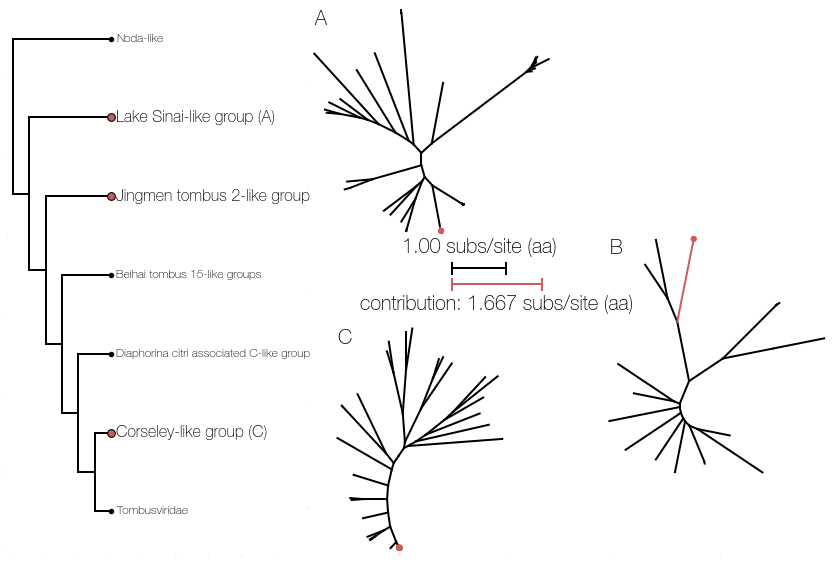

In [10]:
## Tombus

tree='("Noda-like",("Lake Sinai-like group"[&subtree="LakeSinai-like"],("Jingmen tombus 2-like group"[&subtree="JingmenTombus2-like"],("Beihai tombus 15-like groups",("Diaphorina citri associated C-like group",("Corseley-like group"[&subtree="Corseley-like"],"Tombusviridae")))));'


ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'LakeSinai-like': (-0.5,5.5,'A'), 'JingmenTombus2-like': (5,1,'B'), 'Corseley-like': (-2,-1,'C')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Tombus/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=2.5
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+0.3,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan+10)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_tombus.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_tombus.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 6.100000
Tree length: 27.100000
multitype tree
annotations present

Numbers of objects in tree: 16 (8 nodes and 8 leaves)

Camponotus-nipponicus-like
[0.0, 0.00929985000000011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.00929985000000011
Totivirus
[0.3296400300000002, 0.0, 0.0053997099999998355, 0.023018719999999604, 0.06938305999999983, 0.3943331900000002, 0.16343072000000003, 0.7728533999999998, 0.1723803799999999, 0.03467913999999972, 0.04427970999999964, 0.22586204999999993, 0.0072166400000002184, 0.0011277200000003873, 0.006249419999999617, 0.004158600000000234, 0.3000614199999996, 0.28067404000000007, 0.022688999999999737, 0.016614109999999904, 0.0, 0.0, 0.21858387999999973, 0.04077252999999992, 0.027674519999999703, 0.0036607499999998794, 0.0010329599999998607, 0.0020612499999996814, 0.00469981999999991, 0.0052243000000000706, 0.0, 0.0, 0.0010312199999997773] 3.178792289999997
Chryso
[0.2776389899999998, 0.0022908599999995616, 0.0, 0.0] 0.27992984999999937
Omono-river-like
[1

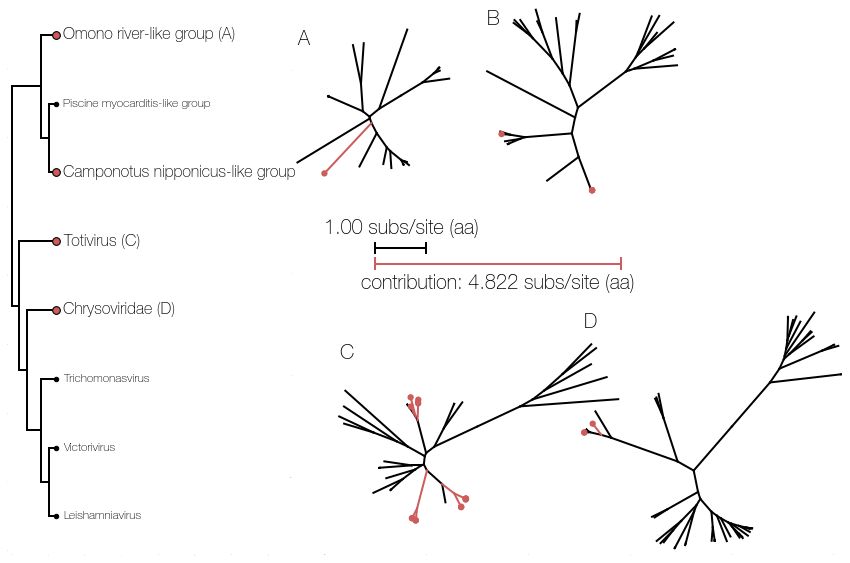

In [11]:
## Toti

tree='((("Piscine myocarditis-like group","Camponotus nipponicus-like group"[&subtree="Camponotus-nipponicus-like"]),"Omono river-like group"[&subtree="Omono-river-like"]),("Totivirus"[&subtree="Totivirus"],("Chrysoviridae"[&subtree="Chryso"],((("Victorivirus","Leishamniavirus"),"Trichomonasvirus")))));'



ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Omono-river-like': (-0.5,5.5,'A'), 'Camponotus-nipponicus-like': (4,6,'B'), 'Totivirus': (1,-1,'C'), 'Chryso': (6,-1,'D')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Toti/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=2.5
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+1,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan+30)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_toti.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_toti.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 9.100000
Tree length: 55.100000
strictly bifurcating tree
annotations present

Numbers of objects in tree: 21 (10 nodes and 11 leaves)

Dicistro
[0.006176350000000053] 0.006176350000000053
Ifla
[0.08614536000000017, 0.03640460999999995, 0.018721100000000046, 0.0, 0.0, 0.000223, 0.005404260000000161, 0.0041999999999999815, 0.017714139999999823, 0.006122989999999717, 0.0, 0.0] 0.17493545999999985
Ifla True
Dicistro True


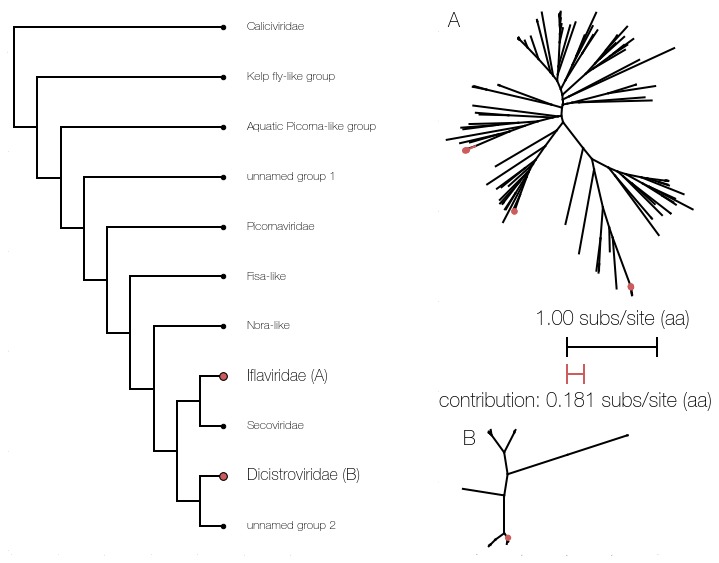

In [12]:
## Picorna

tree='("Caliciviridae",("Kelp fly-like group",("Aquatic Picorna-like group",("unnamed group 1",("Picornaviridae",("Fisa-like",("Nora-like",(("Iflaviridae"[&subtree="Ifla"],"Secoviridae"),("Dicistroviridae"[&subtree="Dicistro"],"unnamed group 2")))))))));'


ll=bt.make_tree(tree)
lvls=max(map(dist2root,ll.Objects))-1.9

for k in ll.getExternal():
    k.height=lvls
    
heightless=ll.getInternal(lambda k: k.height==None)
while len(heightless)>0:
    for k in heightless:
        if len(k.children)==len([ch for ch in k.children if ch.height!=None]):
            k.height=min([ch.height-1 for ch in k.children])
    heightless=ll.getInternal(lambda k: k.height==None)

for k in ll.Objects:
    k.length=k.height-k.parent.height

ll.treeStats()

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(15,10),facecolor='w')

gs = GridSpec(1, 2,width_ratios=[1,2],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax2.set_aspect(1)

trees={}

offset={'Ifla': (-1,5.2,'A'), 'Dicistro': (-1,1.3,'B')}
contribution=0

all_xs=[]
all_ys=[]

for tfile in glob.glob(os.path.join(base_path,'Picorna/*.newick')):
    tname=os.path.basename(tfile).replace('.newick','')
    print(tname)
    subtree=bt.loadNewick(tfile)
#     subtree.treeStats()
    subtree.traverse_tree()
    
    for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=False
            cur_node=cur_node.parent
    
    for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
        cur_node=k
        while cur_node:
            cur_node.traits['bg']=True
            cur_node=cur_node.parent
    
    for pol in pol2contigs:
        contigs=pol2contigs[pol]
        clade=set()
        for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
            cur_node=k
            while cur_node.traits['bg']==False:
                clade.add(cur_node)
                cur_node=cur_node.parent
                
        if len(clade)>0:
            Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
            Ys[pol]=sum([k.length for k in clade])
            Cs[pol]=pol2colour[pol]
    
    blength=subtree.getParameter('length',use_trait=False,which_branches=study)
    print(blength,sum(blength))
    contribution+=sum(blength)
    
#     subtree.sortBranches()
    subtree.drawUnrooted()
    
    x_attr=lambda k: k.x+offset[tname][0]
    y_attr=lambda k: k.y+offset[tname][1]
    label=offset[tname][2]
    
    xs=list(map(x_attr,subtree.Objects))
    ys=list(map(y_attr,subtree.Objects))
    
    all_xs+=xs
    all_ys+=ys
    
    ax2.text(min(xs),max(ys),label,size=20,ha='left',va='top')
    
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
    subtree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=lambda k: 'indianred')
    subtree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),colour_function=lambda k: 'indianred',marker='o')
    trees[tname]=subtree


x=-1
y=2.5
L=1

ax2.plot([x,x+L],[y,y],lw=2,color='k')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
ax2.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

y-=0.3
L=contribution
ax2.plot([x,x+L],[y,y],lw=2,color='indianred')
ax2.plot([x,x],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='indianred')
ax2.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)


ll.sortBranches()
ll.plotTree(ax)
# ll.addText(ax,position=lambda k: (k.x+0.2,k.y),va='center',size=20)

for k in ll.getExternal():
    name=k.numName
    s=12
    if 'subtree' in k.traits:
        print(k.traits['subtree'],k.traits['subtree'] in offset)
        name='%s (%s)'%(name,offset[k.traits['subtree']][2])
        s=16
        ax.scatter(k.x,k.y,s=30,facecolor='indianred',zorder=99)
        ax.scatter(k.x,k.y,s=60,facecolor='k',zorder=98)
        
    ax.text(k.x+1,k.y,name,size=s,zorder=100,va='center',ha='left')
    ax.scatter(k.x,k.y,s=20,facecolor='k',zorder=97)
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines]

ax.tick_params(size=0,labelsize=0)
ax2.tick_params(size=0,labelsize=0)

ax.set_xlim(0,ll.ySpan+1)
ax.set_ylim(0,ll.ySpan-0.1)

pad=0.05
ax2.set_xlim(min([min(all_xs)-pad,x-pad]),max([max(all_xs)+pad,x+contribution+pad]))
ax2.set_ylim(min(all_ys)-pad,max(all_ys)+pad)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_picorna.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_picorna.png',dpi=300,bbox_inches='tight')

plt.show()

In [13]:
from Bio import AlignIO

percent_id={}

def pairwise(seqA,seqB):
    
    L=0
    matches=0
    for a,b in zip(seqA,seqB):
#         print(a,b)
        if a not in ['-','X'] and b not in ['-','X']:
            L+=1
            if a==b:
                matches+=1
                
    return matches/float(L)

for aln_path in glob.glob(os.path.join(base_path,'*/*.fasta')):
    f=AlignIO.read(aln_path,format='fasta')
    L=f.get_alignment_length()
    
    study_seqs={pol: {} for pol in pol2contigs}
    pols_in_aln=set()
    for seq in f:
        if 'CMS' in seq.id: ## study sequence
            for pol in pol2contigs:
                if '|'.join(seq.id.split('|')[1:]) in pol2contigs[pol]: ## sequence part of pol group
                    pols_in_aln.add(pol)
                    study_seqs[pol][seq.id]=seq.seq
    
    closestSeqs={pol: None for pol in pol2contigs}
    minID={pol: 0 for pol in pol2contigs} ## RdRp-focused pID
    for seq in f: ## iterate over all seqs
        if 'CMS' not in seq.id:
            for pol in pols_in_aln: ## iterate over RdRps in aln
                
                pidents=[]
                for cms in study_seqs[pol]: ## iterate over samples
#                     for s in study_seqs[pol][cms]:
#                         print(s)
                    pidents.append(pairwise(seq.seq,study_seqs[pol][cms]))
                
#                 print(pidents)
                pident=max(pidents)
#                 pident=max([sum([0 if (a!=b) else 1 for a,b in zip(seq.seq,study_seqs[pol][cms]) if (a!='-' and b!='-')]) for cms in study_seqs[pol]]) ## get smallest percent ID of study sequences in a particular polymerase group
                
                if pident>=minID[pol]: ## if percent identity is lower - assign it as best score
                    minID[pol]=pident
                    closestSeqs[pol]=seq.id
    
    for pol in pols_in_aln:
        print(os.path.basename(aln_path),pol,closestSeqs[pol],minID[pol])
        percent_id[pol]=minID[pol]

Ifla.fasta 25 QGA87323|Flen_picorna-like_virus|Ochlerotatus_cantans 0.8190854870775348
Ifla.fasta 24 QGA87323|Flen_picorna-like_virus|Ochlerotatus_cantans 0.8131212723658051
Ifla.fasta 23 YP_009553231|Culex_Iflavi-like_virus_4|Culex_sp. 0.9712230215827338
Ifla.fasta 27 AXQ04785|Culex_Iflavi-like_virus_3|Culex_sp. 0.9773371104815864
Dicistro.fasta 60 YP_009345032|Wuhan_insect_virus_33|insects 0.9923076923076923
Orbi-like.fasta 246 AGW51764|uncultured_virus|culicine_sp 0.9152119700748129
Cypo.fasta 296 APG79115|Hubei_reo-like_virus_7|mosquitoes 0.608767576509512
Flavi-like.fasta 12 BAG06229|Culex_flavivirus|Culex_pipiens 0.9966254218222722
Pesti-like.fasta 1 YP_009179225|Shayang_fly_virus_4|Musca_domestica 0.3456
Totivirus.fasta 2923 AJT39587|dsRNA_virus_environmental_sample|Culiseta_incidens 0.7876712328767124
Totivirus.fasta 57 AUI11414|Persimmon_latent_virus|Diospyros_kaki 0.46987951807228917
Totivirus.fasta 49 QGA70954|Salja_virus|Culex_sp. 0.612590799031477
Totivirus.fasta 55 AUI114

{'30': 2, '5': 2, '6': 8, '8': 5, '45': 3, '2': 2, '4': 2, '61': 1, '70': 13, '76': 14, '44': 29, '63': 8, '1160': 1, '1168': 7, '1170': 8, '1181': 3, '226': 1, '416': 1, '1249': 1, '493': 19, '1399': 1, '1438': 1, '9191': 1, '1636': 4, '3110': 3, '3256': 1, '1': 3, '12': 2, '98': 1, '458': 18, '506': 2, '531': 1, '561': 4, '706': 1, '246': 1, '296': 3, '312': 2, '128': 5, '88': 1, '78': 1, '81': 3, '19890': 1, '2923': 1, '42': 3, '49': 1, '55': 2, '56': 1, '57': 1, '354': 1, '60': 1, '23': 1, '24': 1, '25': 1, '27': 2}
{'30': 1.6740742700000002, '5': 0.0024114299999999696, '6': 0.6440107800000004, '8': 0.005744139999999798, '45': 0.001582, '2': 0.37393598999999966, '4': 0.34463626999999963, '61': 0.7313928400000003, '70': 0.5027638000000002, '76': 0.5302719799999999, '44': 0.017270759999999778, '63': 0.4542878200000002, '1160': 0.3569492099999998, '1168': 0.36409356999999964, '1170': 0.01128087000000022, '1181': 0.0019640199999999552, '226': 0.5156125999999999, '416': 1.03652097000000

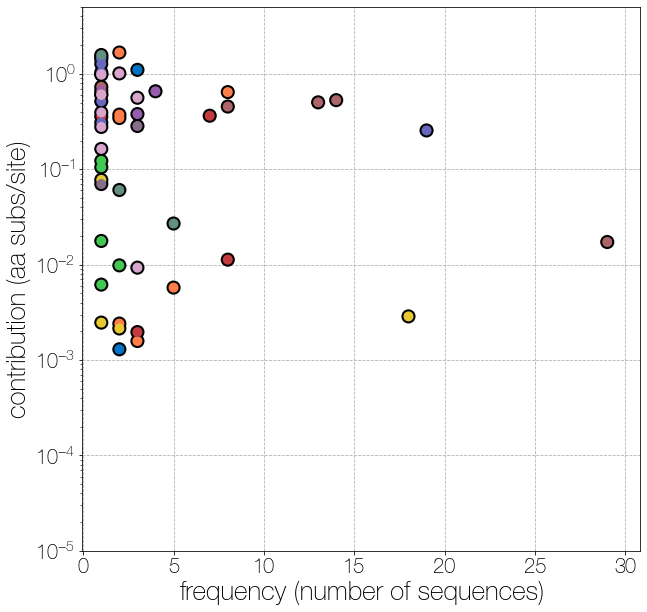

In [14]:
print(Xs)
print(Ys)

fig = plt.subplots(figsize=(10,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

pols=Xs.keys()

ax.scatter([Xs[x] for x in pols],[Ys[x] for x in pols],s=100,facecolor=[Cs[x] for x in pols],edgecolor='none',zorder=100)
ax.scatter([Xs[x] for x in pols],[Ys[x] for x in pols],s=200,facecolor='k',edgecolor='none',zorder=99)

ax.set_xlabel('frequency (number of sequences)',size=26)
ax.set_ylabel('contribution (aa subs/site)',size=26)

ax.tick_params(labelsize=20)
ax.grid(ls='--')

ax.set_yscale('log')

ax.set_xlim(left=-0.05)
ax.set_ylim(0.00001,5)
# ax.set_ylim(bottom=-0.05)
plt.show()

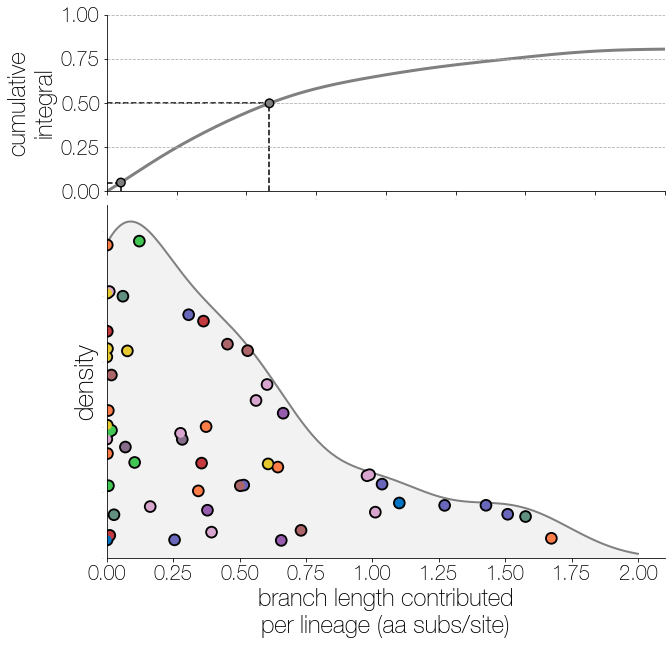

In [15]:
from scipy.stats import gaussian_kde

fig = plt.subplots(figsize=(10,10),facecolor='w')

gs = GridSpec(2, 1,height_ratios=[1,2],hspace=0.05,wspace=0.0)
ax = plt.subplot(gs[1])

kde=gaussian_kde(list(Ys.values()),bw_method=0.4)
x_grid=np.linspace(0,2,200)
y_grid=kde(x_grid)

ax.plot(x_grid,y_grid,color='grey',lw=2,zorder=0)
ax.fill_between(x_grid,y_grid,alpha=0.1,facecolor='grey',edgecolor='none',zorder=0)

p=sorted(pols,key=lambda q: -Ys[q])
x=[Ys[q] for q in p]
y=[np.random.uniform(0.05,kde(i)-0.005) for i in x]
ax.scatter(x,y,s=80,c=[pol2colour[q] for q in p],edgecolor='none',zorder=2)
ax.scatter(x,y,s=160,c='k',edgecolor='none',zorder=1)
# ax.hist(Ys.values(),bins=8,range=(0,2),rwidth=0.9,align='mid',facecolor='slategrey',edgecolor='w',lw=1)


ax.set_ylabel('density',size=26)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',size=0,labelsize=0)

ax.set_xlabel('branch length contributed\nper lineage (aa subs/site)',size=24)


[ax.spines[loc].set_visible(False) for loc in ax.spines if loc in ['top','right']]
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)

ax = plt.subplot(gs[0])

y_grid=[kde.integrate_box_1d(0,x_grid[i]) for i in range(len(x_grid))]

ax.plot(x_grid,y_grid,color='grey',lw=3,zorder=0)


for ct5 in [0.05,0.5]:
    closestTo50=sorted(y_grid,key=lambda x:abs(x-ct5))[0] ## identify slice closest to 0.5
    idx50=list(y_grid).index(closestTo50)

    ax.scatter(x_grid[idx50],y_grid[idx50],s=50,facecolor='grey',edgecolor='none',zorder=3)
    ax.scatter(x_grid[idx50],y_grid[idx50],s=100,facecolor='k',edgecolor='none',zorder=2)
    ax.plot([0,x_grid[idx50]],[y_grid[idx50],y_grid[idx50]],color='k',ls='--',zorder=1)
    ax.plot([x_grid[idx50],x_grid[idx50]],[0,y_grid[idx50]],color='k',ls='--',zorder=1)

ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=0)

ax.set_ylabel('cumulative\nintegral',size=24)
ax.grid(axis='y',ls='--',zorder=0)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc in ['top','right']]

ax.set_ylim(0,1)
ax.set_xlim(0,2)
plt.show()

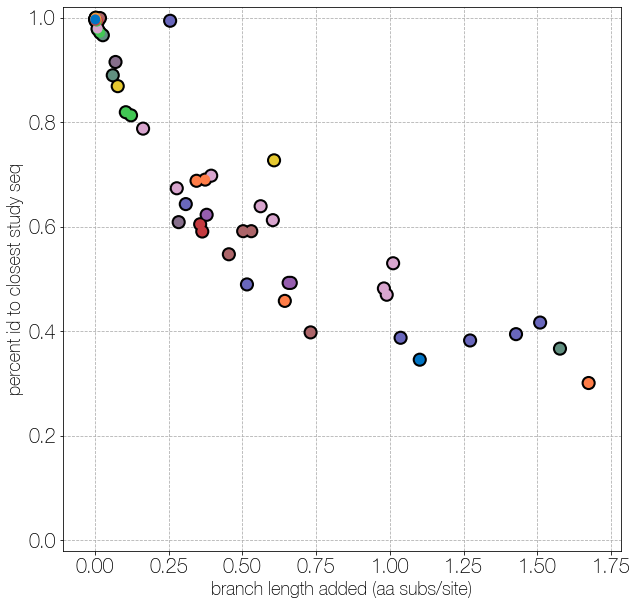

In [16]:
fig = plt.subplots(figsize=(10,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

pols=[y for y in sorted(Ys.keys(),key=lambda w: -Ys[w]) if Ys[y]!=0.0]

ax.scatter([Ys[x] for x in pols],[percent_id[x] for x in pols],s=100,facecolor=[Cs[x] for x in pols],edgecolor='none',zorder=99)
ax.scatter([Ys[x] for x in pols],[percent_id[x] for x in pols],s=200,facecolor='k',edgecolor='none',zorder=98)

ax.set_xlabel('branch length added (aa subs/site)',size=18)
ax.set_ylabel('percent id to closest study seq',size=18)
ax.tick_params(labelsize=20)
# ax.set_xticklabels([])

ax.set_ylim(-0.02,1.02)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(ls='--')
plt.show()

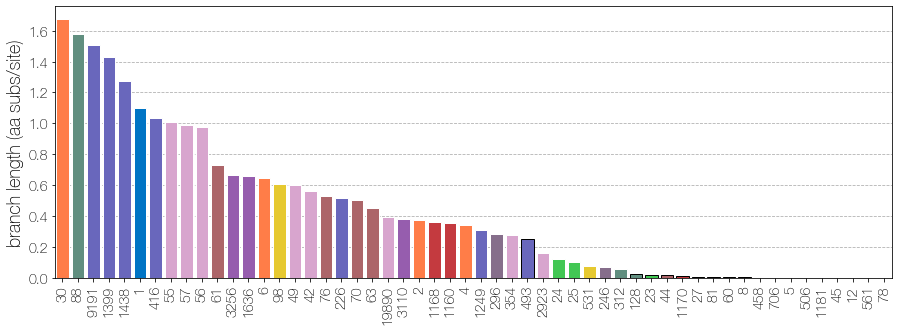

In [17]:
fig = plt.subplots(figsize=(15,5),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

pols=[y for y in sorted(Ys.keys(),key=lambda w: -Ys[w])]
# print(pols)
bars=ax.bar(range(len(pols)),[Ys[y] for y in pols],facecolor='slategrey',edgecolor='w',zorder=10)
# print(p)
for pol,bar in zip(pols,bars):
    bar.set_facecolor(Cs[pol])
    if new_virus[pol]==False:
        bar.set_edgecolor('k')
        
ax.set_xticks(range(len(pols)))
ax.set_xticklabels(pols,rotation=90)
ax.set_ylabel('branch length (aa subs/site)',size=18)
ax.tick_params(labelsize=14)
ax.grid(axis='y',ls='--',zorder=0)
# ax.set_xticklabels([])

ax.set_xlim(-0.5,len(pols)-0.5)
# ax.set_yscale('log')
plt.show()

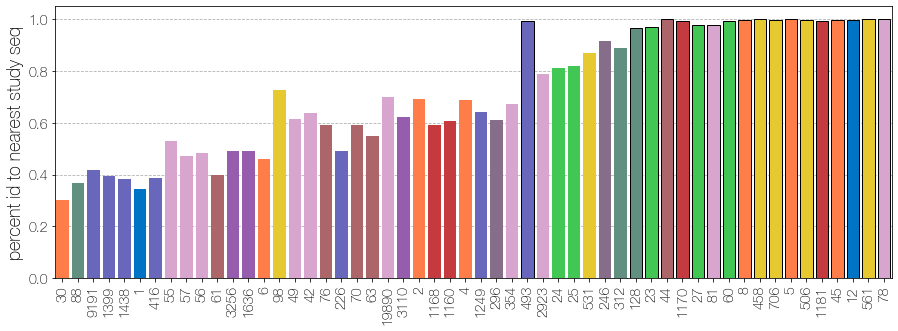

In [18]:
fig = plt.subplots(figsize=(15,5),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

pols=[y for y in sorted(Ys.keys(),key=lambda w: -Ys[w])]
# print(pols)
bars=ax.bar(range(len(pols)),[percent_id[y] for y in pols],zorder=10)
# print(p)
for pol,bar in zip(pols,bars):
    bar.set_facecolor(Cs[pol])
    if new_virus[pol]==False:
        bar.set_edgecolor('k')
        
ax.set_xticks(range(len(pols)))
ax.set_xticklabels(pols,rotation=90)
ax.set_ylabel('percent id to nearest study seq',size=18)
ax.tick_params(labelsize=14)
ax.grid(axis='y',ls='--',zorder=0)
# ax.set_xticklabels([])
ax.set_xlim(-0.5,len(pols)-0.5)
# ax.set_yscale('log')
plt.show()

MottsMills-like
[0.0, 0.0, 0.0024734300000002207, 0.0024675699999998635, 0.007427439999999841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07748476999999987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002141910000000191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0028669799999998524, 0.0028671500000001515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010536309999999993, 0.0] 0.10826555999999998
Orthomyxo
[0.35466467999999995, 0.0, 0.0022845299999998403, 0.0019640199999999552, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36409356999999964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011521899999999974, 0.0, 0.0, 0.002259010000000

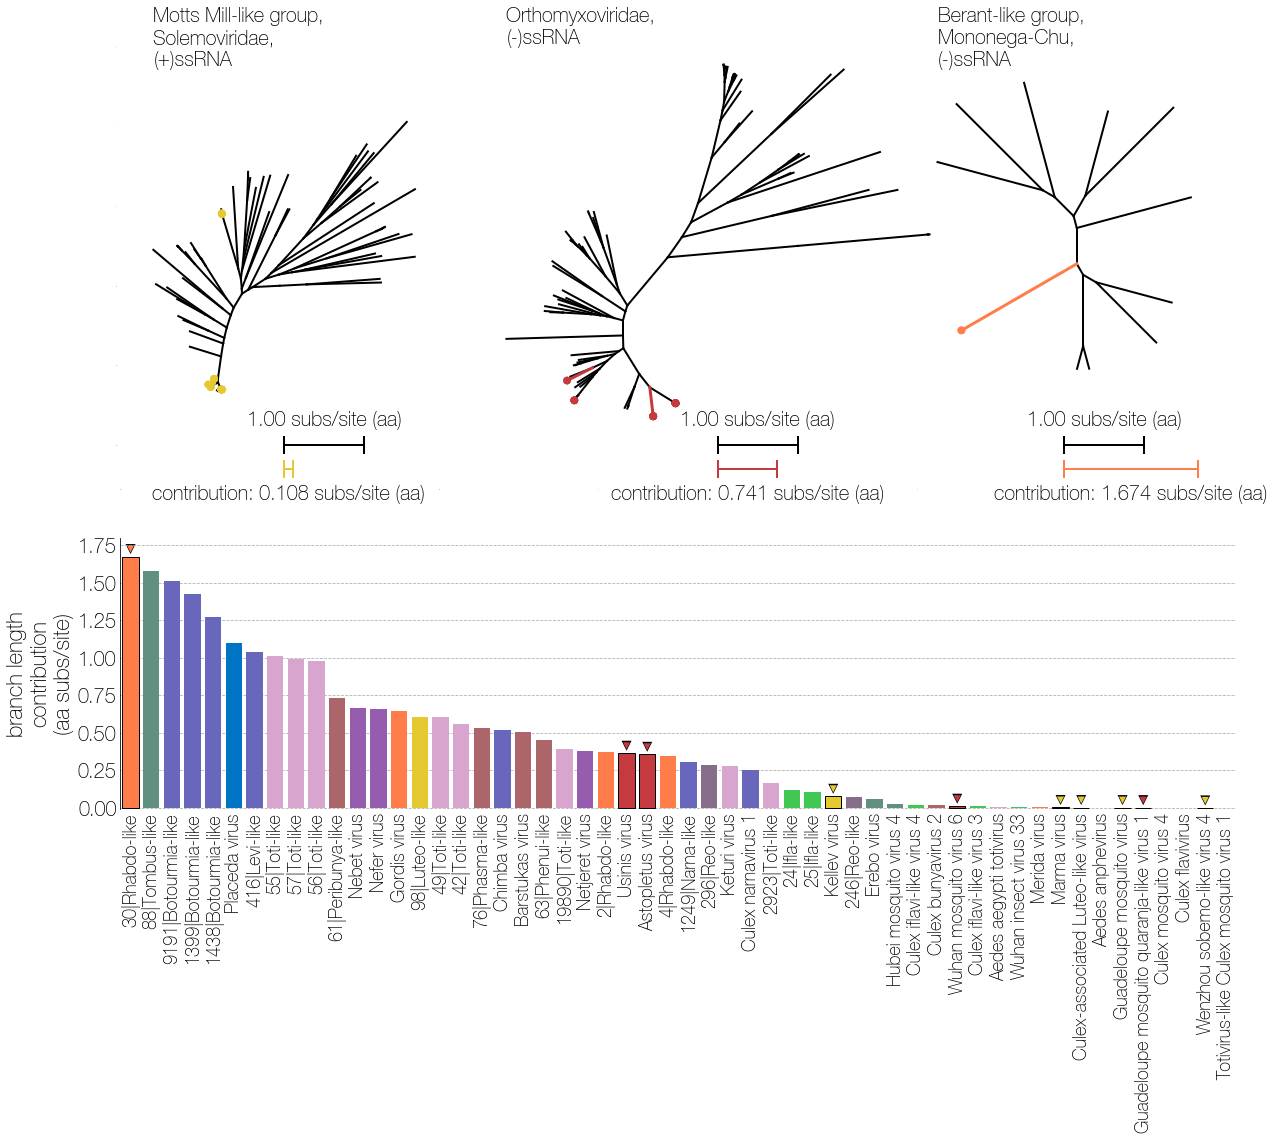

In [19]:
## Orthomyxo

background=lambda k: k.traits['bg']==True
study=lambda k: k.traits['bg']==False

fig = plt.subplots(figsize=(20,15),facecolor='w')

gs = GridSpec(2, 1,height_ratios=[2,1],hspace=0.0,wspace=0.0)
# ax = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])

trees={}

all_xs=[]
all_ys=[]

offset={'MottsMills-like': ('Solemo/MottsMills-like.newick',-4,-1,'Motts Mill-like group, Solemoviridae, (+)ssRNA'), 
        'Orthomyxo': ('Orthomyxo/*.newick',2.5,-0.5,'Orthomyxoviridae, (-)ssRNA'), 
        'Berant-like': ('Mononega-Chu/Rhabdo-like.newick',6,-0.5, 'Berant-like group, Mononega-Chu, (-)ssRNA')}


ax=plt.subplot(gs[0])
ax.set_aspect(1)

pols_in_plots=set()

for v in range(len(offset)):
    vir=['MottsMills-like','Orthomyxo','Berant-like'][v]
    contribution=0
    
    colours=[]
    
    for tfile in glob.glob(os.path.join(base_path,offset[vir][0])):
        tname=os.path.basename(tfile).replace('.newick','')
        print(tname)
        subtree=bt.loadNewick(tfile)
    #     subtree.treeStats()
        subtree.traverse_tree()
        
        for k in subtree.getExternal(lambda w: 'CMS00' in w.numName and 'NODE' in w.numName):
            cur_node=k
            while cur_node:
                cur_node.traits['bg']=False
                cur_node=cur_node.parent

        for k in subtree.getExternal(lambda w: 'CMS00' not in w.numName and 'NODE' not in w.numName):
            cur_node=k
            while cur_node:
                cur_node.traits['bg']=True
                cur_node=cur_node.parent

        for pol in pol2contigs:
            contigs=pol2contigs[pol]
            clade=set()
            for k in subtree.getExternal(lambda w: '|'.join(w.numName.split('|')[1:]) in contigs):
                cur_node=k
                pols_in_plots.add(pol)
                while cur_node.traits['bg']==False:
                    clade.add(cur_node)
                    cur_node=cur_node.parent

            if len(clade)>0:
                colours.append(pol2colour[pol])
#                 Xs[pol]=len([k for k in clade if k.branchType=='leaf'])
#                 Ys[pol]=sum([k.length for k in clade])
#                 Cs[pol]=pol2colour[pol]

        blength=subtree.getParameter('length',use_trait=False,which_branches=study)
        print(blength,sum(blength))

        contribution+=sum(blength)
    #     subtree.sortBranches()
        subtree.drawUnrooted()

        x_attr=lambda k: k.x+offset[vir][1]
        y_attr=lambda k: k.y+offset[vir][2]

        xs=list(map(x_attr,subtree.Objects))
        ys=list(map(y_attr,subtree.Objects))

        all_xs+=xs
        all_ys+=ys

        ax.text(min(xs),2.5,', \n'.join(offset[vir][3].split(', ')),size=20,ha='left',va='top')
        c_func=lambda k: colours[0]
        s_func=lambda k: 60
        b_func=lambda k: 3
        subtree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=background,colour_function=lambda k: 'k')
        subtree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,type='unrooted',target=study,colour_function=c_func,branchWidth=b_func)
        subtree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,target=lambda k: (study(k) and k.branchType=='leaf'),size_function=s_func,colour_function=c_func,marker='o')
#         trees[tname]=subtree


    x=min(xs)+(max(xs)-min(xs))/2#offset[virus][1]-1
    y=-3
    L=1

    ax.plot([x,x+L],[y,y],lw=2,color='k')
    ax.plot([x,x],[y-0.1,y+0.1],lw=2,color='k')
    ax.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color='k')
    ax.text(x+L/2,y+0.2,'%.2f subs/site (aa)'%(L),ha='center',va='bottom',size=20)

    y-=0.3
    L=contribution
    ax.plot([x,x+L],[y,y],lw=2,color=colours[0])
    ax.plot([x,x],[y-0.1,y+0.1],lw=2,color=colours[0])
    ax.plot([x+L,x+L],[y-0.1,y+0.1],lw=2,color=colours[0])
    ax.text(x+L/2,y-0.2,'contribution: %.3f subs/site (aa)'%(L),ha='center',va='top',size=20)
    
#     ax.plot([x,x+L],[y,y],lw=8,color='k',zorder=0)
#     ax.plot([x,x],[y-0.1,y+0.1],lw=8,color='k',zorder=0)
#     ax.plot([x+L,x+L],[y-0.1,y+0.1],lw=8,color='k',zorder=0)


[ax.spines[loc].set_visible(False) for loc in ax.spines]

ax.tick_params(size=0,labelsize=0)

ax.set_xlim(-6,8)
ax.set_ylim(-3.5,2)


ax2=plt.subplot(gs[1])

pols=[y for y in sorted(Ys.keys(),key=lambda w: -Ys[w])]
# print(pols)
bars=ax2.bar(range(len(pols)),[Ys[y] for y in pols],zorder=10)
# print(p)
for pol,bar in zip(pols,bars):
    bar.set_facecolor(Cs[pol])
    if pol in pols_in_plots:
#         y=Ys[pol]+Ys[pol]*0.15+0.001
        y=Ys[pol]+0.05
        ax2.scatter(pols.index(pol),y,s=50,facecolor=pol2colour[pol],edgecolor='none',marker='v')
        ax2.scatter(pols.index(pol),y,s=100,facecolor='k',edgecolor='none',marker='v',zorder=0)
        bar.set_edgecolor('k')
        
ax2.set_xticks(range(len(pols)))
ax2.set_xticklabels([virus[p]['name'] if 'provisional_name' not in virus[p] else virus[p]['provisional_name'] for p in pols],rotation=90)
ax2.set_ylabel('branch length\ncontribution\n(aa subs/site)',size=22)
ax2.tick_params(axis='y',size=0,labelsize=20)
ax2.tick_params(axis='x',size=0,labelsize=18)
ax2.grid(axis='y',ls='--',zorder=0)
# ax.set_xticklabels([])
ax2.set_xlim(-0.5,len(pols)-0.5)
ax2.set_ylim(-0.01,1.8)
# ax2.set_yscale('log')
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['left']]

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_branchLength.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig7_branchLength.png',dpi=300,bbox_inches='tight')

plt.show()